In [2]:
import os
import sys
import json
import datetime
import requests
import pendulum
import logging
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from airflow import DAG
from urllib import parse
from airflow.models import Variable
from concurrent.futures import ThreadPoolExecutor
from airflow.operators.python import PythonOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.providers.postgres.hooks.postgres import PostgresHook

warehouse_hook = PostgresHook(postgres_conn_id='airflow_warehouse_user', schema='ubuntu')
gateway_hook = MySqlHook(mysql_conn_id='gateway_server', schema='bloom_staging')
mifos_hook = MySqlHook(mysql_conn_id='mifos_db', schema='mifostenant-safaricom')


/tmp/ipykernel_18784/841911553.py:21 DeprecationWarning: The "schema" arg has been renamed to "database" as it contained the database name.Please use "database" to set the database name.

/tmp/ipykernel_18784/841911553.py:21 DeprecationWarning: The "schema" arg has been renamed to "database" as it contained the database name.Please use "database" to set the database name.

## TEP Balance Issues File

In [3]:
dt2 = pd.read_excel('~/data2/TEP Balance Issues.xlsx', skiprows=1)

In [4]:
lns = warehouse_hook.get_pandas_df(
    sql="""
        select
            lftmsv.disbursed_on_date, lftmsv.loan_mifos_id, lftmsv.total_outstanding, lftmsv.safaricom_loan_balance,
            lftmsv.safaricom_loan_balance_date, lftmsv.loan_status,
            td.transaction_date as latest_mifos_repayment_date,
            DATE_PART('day', age(td.transaction_date, date(safaricom_loan_balance_date))) as days_between_mifos_and_safaricom_balance,
            DATE_PART('day', age(current_date, date(safaricom_loan_balance_date))) as days_since_safaricom_balance_update,
            safaricom_loan_balance - total_outstanding as balance_variance,
            td.receipt_number
        from bloomlive.loans_fact_table_materialized_summary_view lftmsv
        left join bloomlive.transactions_data_dump tdd on lftmsv.latest_dump_repayment_key = tdd.surrogate_id
        left join bloomlive.raw_tep_repayments rtr on lftmsv.latest_tep_repayment_key = rtr.surrogate_id
        left join bloomlive.statement_details_data_dump sddd on lftmsv.latest_dump_statement_key = sddd.surrogate_id
        left join (
            select mifos_loan_id, receipt_number, transaction_date, bloom_version, created_date, rank() over (partition by mifos_loan_id order by transaction_date desc, created_date desc, transaction_id desc) rnk
            from bloomlive.transactions_dimension td where is_repayment
        ) td on lftmsv.loan_mifos_id = td.mifos_loan_id::int and td.bloom_version = lftmsv.bloom_version and td.rnk = 1
        where lftmsv.bloom_version = 2 and safaricom_loan_balance is not null and lftmsv.loan_status = 300
    """
).drop_duplicates()

[2023-03-10 10:55:31,345] {base.py:73} INFO - Using connection ID 'airflow_warehouse_user' for task execution.


/home/henrykuria/airflow_venv/lib/python3.10/site-packages/pandas/io/sql.py:761 UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

In [5]:
lns[lns.duplicated(subset=[''])]
# 249308

KeyError: Index([''], dtype='object')

In [7]:
incorrect_safaricom_balance = lns[(lns['loan_status'] == 300) & (lns['safaricom_loan_balance'] != 0) &
    (lns['safaricom_loan_balance'] >= lns['total_outstanding']) &
    (pd.to_datetime(lns['safaricom_loan_balance_date']).dt.date < lns['latest_mifos_repayment_date'])][[
    'loan_mifos_id', 'disbursed_on_date', 'total_outstanding', 'safaricom_loan_balance', 'balance_variance', 'days_since_safaricom_balance_update', 'days_between_mifos_and_safaricom_balance', 'safaricom_loan_balance_date', 'latest_mifos_repayment_date', 'loan_status', 'receipt_number'
]].dropna(subset='safaricom_loan_balance')


print(f"Total MIFOS Outstanding Sum: {incorrect_safaricom_balance['total_outstanding'].sum()}")
print(f"Total TEP Outstanding Sum: {incorrect_safaricom_balance['safaricom_loan_balance'].sum()}")


Total MIFOS Outstanding Sum: 2649159.1399999997
Total TEP Outstanding Sum: 32203461.869999997


In [8]:
incorrect_safaricom_balance[~incorrect_safaricom_balance['receipt_number'].str.contains('waiv', case=False)]

,loan_mifos_id,disbursed_on_date,total_outstanding,safaricom_loan_balance,balance_variance,days_since_safaricom_balance_update,days_between_mifos_and_safaricom_balance,safaricom_loan_balance_date,latest_mifos_repayment_date,loan_status,receipt_number
219,299881,2023-01-29,27.00,899.84,872.84,6.0,1.0,2023-02-04,2023-02-05,300,RB55Z68UFL
768,260609,2022-12-01,45.02,974.88,929.86,4.0,1.0,2022-12-06 08:23:08,2022-12-07,300,QL75LRELV1
794,296201,2023-01-12,38.35,731.20,692.85,26.0,1.0,2023-01-15 11:31:02,2023-01-16,300,RAG6HNI7OC
934,240235,2022-10-31,27.10,928.97,901.87,8.0,1.0,2022-12-02 21:31:57,2022-12-03,300,QL30AM5QFC
4044,264263,2022-12-10,16.97,2353.51,2336.54,21.0,1.0,2022-12-20,2022-12-21,300,QLL0ONY1DA
...,...,...,...,...,...,...,...,...,...,...,...
225753,251705,2022-11-13,99.14,1552.32,1453.18,7.0,1.0,2022-12-03,2022-12-04,300,QL40BXRM2U
226569,293600,2023-01-04,180.55,1957.97,1777.42,27.0,1.0,2023-01-14,2023-01-15,300,RAF3H36HKF
226571,300811,2023-02-02,357.27,4987.28,4630.01,16.0,1.0,2023-02-22 22:39:54,2023-02-23,300,RBN7CFRRBP
228202,303444,2023-02-21,26.96,925.34,898.38,8.0,1.0,2023-03-02 15:14:07,2023-03-03,300,RC31WLJLC1


In [9]:
print(dt2.shape)
dt2[~dt2['LOAN ID'].isin(incorrect_safaricom_balance['loan_mifos_id'].tolist())]

(64, 4)


,Unnamed: 0,LOAN ID,Mifos bal as at 8.32023,TEP bal as at 8.3.2023
10,NaN,300260,626.7,10065.04
23,NaN,303548,36836.07,34751.44
26,NaN,303917,"98,588,00",102276.77
31,NaN,302691,18127.57,18258.23
34,NaN,304385,1246.84,1205.76
38,NaN,302497,1145.06,1145.05
54,NaN,301725,18100.21,16953.60
57,NaN,303797,522.04,499.60


In [10]:
lns2 = lns[lns['loan_mifos_id'].isin(dt2['LOAN ID'].tolist())]
warehouse_hook.get_pandas_df(
    sql="""
    select * from bloomlive.raw_tep_repayments where fund_movement_transaction_id in %(fmti)s
    """,
    parameters={'fmti': tuple(lns2['receipt_number'].tolist())}
)

[2023-03-10 11:18:39,775] {base.py:73} INFO - Using connection ID 'airflow_warehouse_user' for task execution.


/home/henrykuria/airflow_venv/lib/python3.10/site-packages/pandas/io/sql.py:761 UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

,surrogate_id,request_id,loan_contract_id,due_date,loan_amount,loan_request_date,loan_balance,store_number,sender_name,recipient_name,transaction_date_time,paid_amount,notification_description,lender_id,fund_movement_transaction_id,record_created_on_timestamp,gateway_id,status_code,failure_reason
0,658463,L0638101HUX09201515984,110100000031010922,2023-03-12,9354.95,2023-03-08 07:12:41,1145.05,252498,IMANI HOLDING,Asante 21 Day Loan @ 9.12%,2023-03-08 07:12:41,11000.0,Repay A Loan,10003,RC87A8OV3V,2023-03-08 07:30:37.855441,None,200,Accept the service request successfully


### Visualization

199821
1035


<Figure size 576x1152 with 0 Axes>

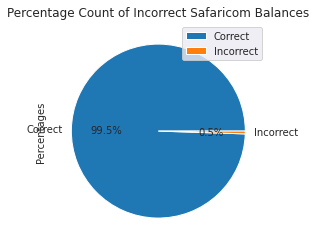

In [11]:
total_ln_rows = lns.shape[0]
total_incorrect_rows = incorrect_safaricom_balance.shape[0]
incorrect_percentage = (total_incorrect_rows / total_ln_rows) * 100
print(total_ln_rows)
print(total_incorrect_rows)
correct_percentage = 100 - incorrect_percentage

data = {'Labels': ['Correct', 'Incorrect'],
        'Percentages': [correct_percentage, incorrect_percentage]}
df = pd.DataFrame(data)

plt.figure(figsize=(8,16))
df.plot(kind='pie', y='Percentages', labels=df['Labels'], autopct='%1.1f%%')
plt.title('Percentage Count of Incorrect Safaricom Balances')
plt.show()


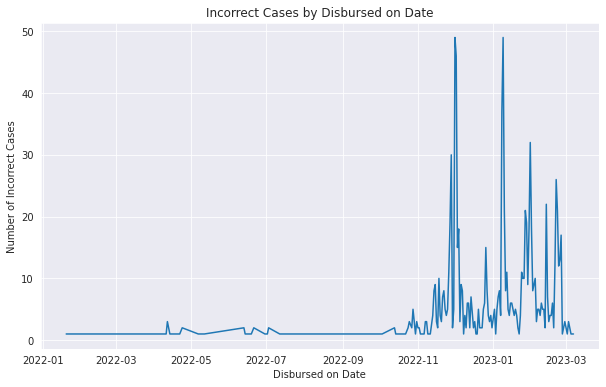

In [12]:
# Group by disbursed on date and count number of rows
incorrect_by_date = incorrect_safaricom_balance.groupby('disbursed_on_date').size()

# Plot as a line chart
plt.figure(figsize=(10, 6))
plt.plot(incorrect_by_date.index, incorrect_by_date.values)
plt.xlabel('Disbursed on Date')
plt.ylabel('Number of Incorrect Cases')
plt.title('Incorrect Cases by Disbursed on Date')
plt.show()

# Does not follow a pattern

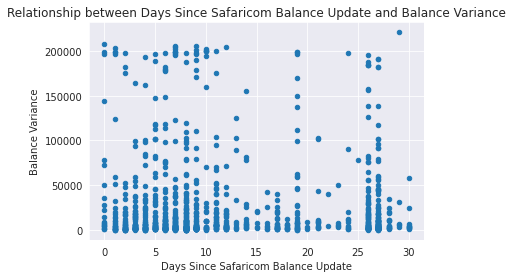

In [13]:
incorrect_safaricom_balance.plot(kind='scatter', x='days_since_safaricom_balance_update', y='balance_variance')
plt.title('Relationship between Days Since Safaricom Balance Update and Balance Variance')
plt.xlabel('Days Since Safaricom Balance Update')
plt.ylabel('Balance Variance')
plt.show()

# This will create a scatter plot showing the relationship between days_since_safaricom_balance_update and balance_variance. We can use this plot to analyze the trend and relationship between the two variables. For example, we can observe if there is any correlation between days_since_safaricom_balance_update and balance_variance. We can also look for any outliers or patterns in the data.


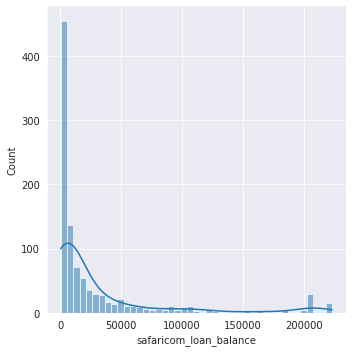

In [14]:
# Plot the distribution of safaricom loan balance
sns.displot(incorrect_safaricom_balance, x='safaricom_loan_balance', kde=True)
plt.show()

Text(0.5, 1.0, 'Monthly Distribution of Incorrect Cases')

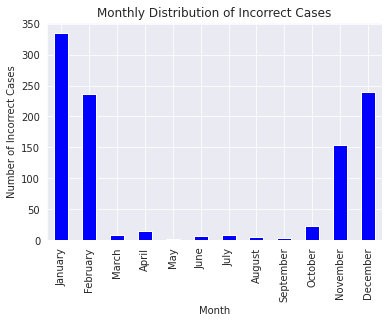

In [15]:
# create a new column with the month name
incorrect_safaricom_balance['month'] = pd.to_datetime(incorrect_safaricom_balance['disbursed_on_date']).dt.month_name()

# define a custom order for the month names
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# convert the `month` column to categorical with the custom order
incorrect_safaricom_balance['month'] = pd.Categorical(incorrect_safaricom_balance['month'], categories=month_order, ordered=True)

# group the dataframe by month and count the number of incorrect cases
incorrect_counts = incorrect_safaricom_balance.groupby('month')['loan_mifos_id'].count()

# create a barplot with seaborn
# ax = sns.barplot(x='month', y='loan_mifos_id', data=incorrect_counts.reset_index())
ax = incorrect_counts.plot(kind='bar', color='blue')

# set axis labels and plot title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Incorrect Cases')
ax.set_title('Monthly Distribution of Incorrect Cases')

Text(0.5, 1.0, 'Monthly Distribution of Incorrect Cases')

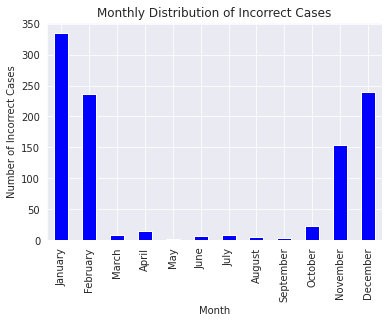

In [17]:
incorrect_safaricom_balance['month'] = pd.to_datetime(incorrect_safaricom_balance['disbursed_on_date']).dt.strftime('%b %Y')
incorrect_counts = incorrect_safaricom_balance.groupby('month')['loan_mifos_id'].count().reset_index(name='count')

# Add the following code to order the months
incorrect_counts['month'] = pd.to_datetime(incorrect_counts['month'], format='%b %Y').dt.strftime('%Y-%m')
incorrect_counts = incorrect_counts.sort_values('month')

ax = sns.barplot(x='month', y='count', data=incorrect_counts, color='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Incorrect Cases')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()


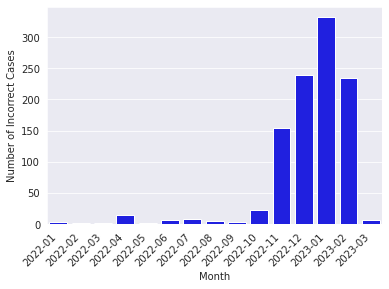

In [16]:
# Find the count of rows with 'waiv' in receipt_number column
waiver_count = incorrect_safaricom_balance[incorrect_safaricom_balance['receipt_number'].str.contains('waiv', case=False)].shape[0]

# Find the count of rows without 'waiv' in receipt_number column
non_waiver_count = len(incorrect_safaricom_balance) - waiver_count

# Plot the results as a pie chart
plt.pie([waiver_count, non_waiver_count], labels=['Waivers', 'Non-waivers'], autopct='%1.1f%%')
plt.title('Percentage of Incorrect Cases Closed as Waivers')
plt.show()


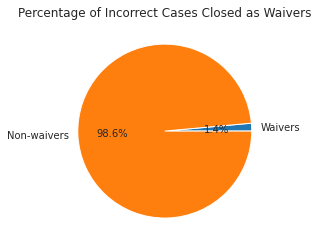

In [18]:
# Group the data by latest_mifos_repayment_date and count the number of loans for each date
latest_repayment_counts = incorrect_safaricom_balance.groupby('latest_mifos_repayment_date')['loan_mifos_id'].count()

# Plot the counts as a line plot
latest_repayment_counts.plot(kind='line', figsize=(12, 6))
plt.title('Latest Mifos Repayment Date')
plt.xlabel('Latest Mifos Repayment Date')
plt.ylabel('Number of Loans')
plt.show()
